In [3]:
import numpy
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("./data/household_power_consumption_daily.csv", parse_dates=True, index_col=0)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.934
2006-12-17,3390.460,226.006,345725.30,14398.6,2033.0,4187.0,13341.0,36946.668
2006-12-18,2203.826,161.792,347373.62,9247.2,1063.0,2621.0,14018.0,19028.434
2006-12-19,1666.194,150.942,348479.00,7094.0,839.0,7602.0,6197.0,13131.900
2006-12-20,2225.748,160.998,348923.62,9313.0,0.0,2648.0,14063.0,20384.800


In [5]:
def split_data(data):
    train, test = data[1: -328], data[-328:-6]
    train = numpy.array(numpy.split(train, len(train)/7))
    test = numpy.array(numpy.split(test, len(test)/7))
    return train, test

In [6]:
train, test = split_data(df.values)

In [7]:
train.shape

(159, 7, 8)

In [59]:
def reshape_nn_input(X: numpy, n_input: int, n_output=7):
    data = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
    print(data.shape)
    x, y = list(), list()

    first_input = 0

    for _ in range(len(data)):
        last_input = first_input + n_input
        last_output = last_input + n_output

        if last_output <= len(data):
            x_in = data[first_input:last_input, 0]
            x_in = x_in.reshape(len(x_in), 1)
            x.append(x_in)
            y.append(data[last_input:last_output, 0])
        first_input += 1
    return numpy.array(x), numpy.array(y)


In [61]:
train_input, train_output = reshape_nn_input(train, 7)

(1113, 8)


In [62]:
train_input.shape, train_output.shape

((1100, 7, 1), (1100, 7))

In [64]:
def conv_model(x: numpy, y: numpy):
    timestamps, features, num_outputs = x.shape[1], x.shape[2], y.shape[-1]
    model = keras.Sequential()
    model.add(keras.layers.Conv1D(16, 5, activation='relu', input_shape=(timestamps, features)))
    model.add(keras.layers.MaxPooling1D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(49, activation=keras.activations.relu))
    model.add(keras.layers.Dense(num_outputs))

    model.compile(
        loss=keras.losses.mean_absolute_error,
        optimizer=keras.optimizers.Adam()
    )
    history = model.fit(x, y, epochs=52, batch_size=5)
    return history, model

In [65]:
history, model = conv_model(train_input, train_output)

2023-01-02 12:19:45.891791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-02 12:19:45.894146: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-02 12:19:45.896308: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vhyne): /proc/driver/nvidia/version does not exist
2023-01-02 12:19:45.902865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/52
220/220 [==============================] - 1s 2ms/step - loss: 586.9348
Epoch 2/52
220/220 [==============================] - 0s 2ms/step - loss: 391.8366
Epoch 3/52
220/220 [==============================] - 0s 2ms/step - loss: 388.2935
Epoch 4/52
220/220 [==============================] - 0s 2ms/step - loss: 384.4273
Epoch 5/52
220/220 [==============================] - 0s 2ms/step - loss: 382.9661
Epoch 6/52
220/220 [==============================] - 0s 1ms/step - loss: 381.8245
Epoch 7/52
220/220 [==============================] - 0s 1ms/step - loss: 381.4474
Epoch 8/52
220/220 [==============================] - 0s 1ms/step - loss: 380.5691
Epoch 9/52
220/220 [==============================] - 0s 1ms/step - loss: 378.7929
Epoch 10/52
220/220 [==============================] - 0s 1ms/step - loss: 378.0551
Epoch 11/52
220/220 [==============================] - 0s 1ms/step - loss: 375.5930
Epoch 12/52
220/220 [==============================] - 0s 1ms/step - loss: 375.0617
E

In [104]:
def model_prediction(model, x: numpy, n_inputs=7):
    # data = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    # print(data.shape)

    last_week = x[-1][:,0]
    print(last_week.shape)
    last_week = last_week.reshape((1, len(last_week), 1))

    yhat = model.predict(last_week, verbose=2)

    return yhat

In [83]:
train_input.shape

(1100, 7, 1)

In [84]:
train[-1][:, 0]

array([2195.452, 2094.098, 2047.968, 2451.11 , 2211.892, 1224.252,
       1309.268])

In [85]:
yhat = model_prediction(model=model, x=train)

(7,)
1/1 [==============================] - 0s 81ms/step


In [86]:
yhat

array([[1928.2244, 1777.0726, 1777.4382, 2110.6697, 1923.015 , 1774.746 ,
        1959.5951]], dtype=float32)

In [90]:
def flatten_shape(array: numpy):
    array_multiplication = array.shape[0] * array.shape[1]
    return numpy.reshape(array, (array_multiplication,))

In [92]:
yhat_values = flatten_shape(yhat)

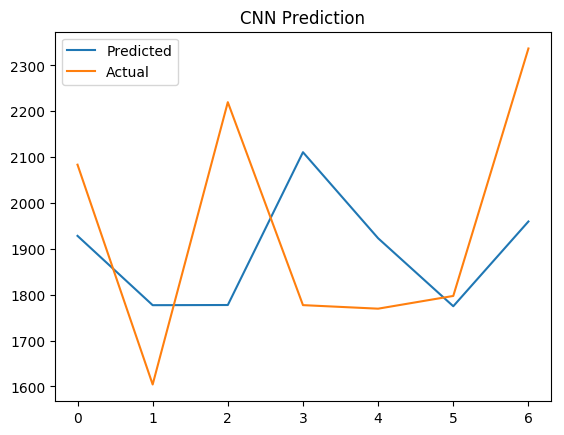

In [95]:
plt.figure()
plt.plot(yhat_values, label="Predicted")
plt.plot(test[0][:,0], label="Actual")
plt.title("CNN Prediction")
plt.legend()
plt.show()

In [118]:
def rmse_evaluation(actual: numpy, predicted: numpy):
    scores = list()

    for i in range(actual.shape[1]):
        rmse = numpy.sqrt(mean_squared_error(actual[:, i], predicted[:, i]))
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = numpy.sqrt(s/(actual.shape[0] * actual.shape[1]))
    return score, scores

def evaluate_model(model, train, test):
    history = [obs for obs in train]
    predictions = list()

    for v in range(len(test)):
        yhat = model_prediction(model=model, x=history)
        predictions.append(yhat)
        history.append(test[v, :])
    predictions = numpy.array(predictions)
    predictions = predictions.reshape((46,7))
    # return predictions
    score, scores = rmse_evaluation(test[:,:,0], predictions)
    return score, scores

def sunnarize_scores(name, score, scores):
    n_scores = ", ".join(["%.1f"%s for s in scores ])
    print("%s: {%.3f} %s" % (name, score, n_scores))

def model_prediction(model, x: numpy, n_inputs=7):
    data = numpy.array(x)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))

    last_week = x[-1][:,0]
    last_week = last_week.reshape((1, len(last_week), 1))

    yhat = model.predict(last_week, verbose=0)

    return yhat

CNN: {399.192} 432.1, 399.2, 362.1, 372.4, 400.6, 320.5, 486.3


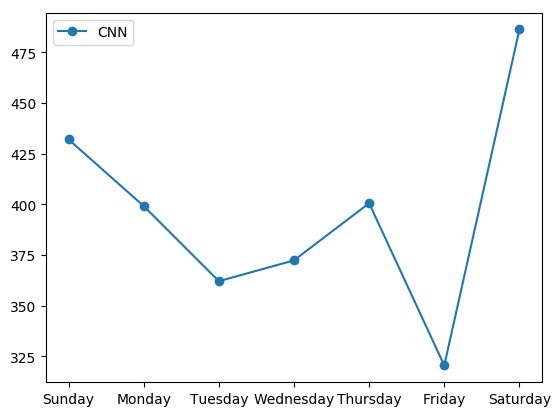

In [119]:
days = ["Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
score, scores = evaluate_model(model=model, train=train, test=test)
sunnarize_scores("CNN", score,scores)

plt.plot(days, scores, marker='o', label="CNN")
plt.legend()
plt.show()